- it's debatable whether this topic even qualifies as "deep learning" because we're going to see how to build a pretty good recommender system without using a neural network at all! We will, however, take advantage of the power of a modern computation framework like Keras to implement the recommender with minimal code. We'll try a couple different approaches using a technique called collaborative filtering. Finally we'll build a true neural network and see how it compares to the collaborative filtering approach.


- neural network(신경망) 같은 딥러닝을 쓰지 않아도 꽤 좋은 추천 시스템을 만들 수 있다. 그렇다면, 딥러닝은 왜 쓰는가?
- 더 코드가 단순하다!
- 더 많은 데이터를 사용할 수 있다!

## Collaborative Filtering(CF)
- 전처리 과정

출처 : https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('new_df.csv')
df.head()

,Unnamed: 0,beer_id,username,look,smell,taste,feel,overall,score
0,0,271781,bluejacket74,4.00,4.00,4.0,4.25,4.00,4.03
1,9449,78043,bluejacket74,3.50,4.00,3.5,3.50,3.50,3.62
2,10982,225791,bluejacket74,4.25,4.00,4.0,3.75,4.00,3.99
3,17441,77030,bluejacket74,3.50,3.75,4.0,3.75,3.75,3.84
4,18672,47658,bluejacket74,4.50,5.00,5.0,5.00,5.00,4.97


In [3]:
print(df.shape) #중간발표 때 1차 전처리를 했던 440만개의 데이터를 활용하였다.

(4403885, 9)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,78043,bluejacket74,3.62
2,225791,bluejacket74,3.99
3,77030,bluejacket74,3.84
4,47658,bluejacket74,4.97


## LabelEncoder
- user/beer 컬럼은 지금은 non-sequentail integer이다. 그러므로 unique ID를 나타내는 것으로 value를 바꿔주어야 한다.
- 이 때 이용하는 것이 바로 'labelencoder()' <-발표자료에는 이것의 설명도 추가.(캡처확인)
- 이를 이용하면 모델링을 위해, 변수의 value를 0부터 시작되는 숫자로 바꿀 수 있다. (숫자->숫자도 되고 문자->숫자도 된다.)

In [5]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['userid'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(9012, 154711, 1.0, 5.0)

In [6]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,5227,129595,4.03
1,5227,43239,3.62
2,5227,112870,3.99
3,5227,42548,3.84
4,5227,24908,4.97


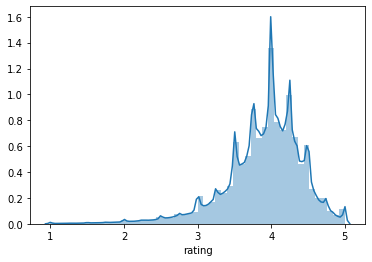

In [7]:
#rating의 분포 - 3,4,5점에 편중된 데이터.
sns.distplot(df2['rating'])
plt.show()

- we will deal with rating as "continuous" as we are ok with predicting intermediate values.
- the data is unbalanced, and most of the ratings are from 3 to 5. (Ideally we should consier the impact of such imbalance on the model)

In [8]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3523108, 2), (880777, 2), (3523108,), (880777,))

In [9]:
X_train

array([[ 2536, 47704],
       [ 6471,  3864],
       [ 3774, 41147],
       ...,
       [ 7422, 93757],
       [ 8111,  1516],
       [ 8160, 78494]], dtype=int64)

In [10]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [11]:
X_train_array

[array([2536, 6471, 3774, ..., 7422, 8111, 8160], dtype=int64),
 array([47704,  3864, 41147, ..., 93757,  1516, 78494], dtype=int64)]

# Recommdation System using Keras 
- 각 유저와 각 맥주를 나타내기 위해 'embedding'이라는 것을 활용한다.->(설명부분 캡처)
- 'embeddings'는 벡터이다(n_factor 사이즈의). 시작은 랜덤한 숫자로 가고, 각 유저/맥주의 필수적인 특징을 잡으면 fit model을 해보자.
- fit model 과정) 유저 벡터와 맥주 벡터를 스칼라곱(dot product)하여 예측 평점을 계산함.
- 이를 위해선 유니크한 유저 수와 맥주 수가 필요, -> 각각의 embedding matrix의 사이즈를 정의하기 위함.

- Now we get to the model itself. The main idea here is we're going to use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) that start out as random numbers but are fit by the model to capture the essential qualities of each user/movie. We can accomplish this by computing the dot product between a user vector and a movie vector to get a predicted rating. The code is fairly simple, there isn't even a traditional neural network layer or activation involved. I stuck some regularization on the embedding layers and used a different initializer but even that probably isn't necessary. Notice that this is where we need the number of unique users and movies, since those are required to define the size of each embedding matrix.

In [12]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda

Using TensorFlow backend.


## RecommenderV2 함수
- 각각의 embedding에 'bias'를 추가해보자.
- input : n_users(# of unique users), n_beers(# of uniuqe beers), n_factors(# of 잠재요인)
- 이 함수를 사용하면 예측평점 계산하기가 아주 간편하다.(역시 계산이 간단한 딥러닝^-^)

- 참고(케라스 사전: embedding): https://keras.io/layers/embeddings/

In [13]:
#I also refactored the code a bit by pulling out the embedding layer 
# and reshape operation into a separate class.

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', 
                      #initializer는 정규분포
                      embeddings_regularizer=l2(1e-6))(x) #정규화
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV2(n_users, n_beers, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user)
    
    beer = Input(shape=(1,))
    m = EmbeddingLayer(n_beers, n_factors)(beer) #m은 beer * n_factor
    mb = EmbeddingLayer(n_beers, 1)(beer)

    x = Dot(axes=1)([u, m]) #예측행렬 R_hat은 u*m을 한 것.
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.002) #learning rate(학습률) 설정. #optimizer인 최적화 방법은 Adam을 씀.
    #Adam 알고리즘 설명: https://forensics.tistory.com/28
    #학습률 설정은 경사하강법, sgd 등 여러 가지를 쓸 수 있는데, 예시 코드에서 adam을 써서..
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) #loss와 함께 출력할 mae, mse는 metrics로 설정.

    return model

In [14]:
model = RecommenderV2(n_users, n_beers, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        450600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        7735550     input_2[0][0]                    
____________________________________________________________________________________________

## 모델 train셋에 학습
예: model.fit(x, y, batch_size=32, epochs=10)
- x: 입력 데이터
- y: 라벨 값
- batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 지정 (작을수록 가중치 갱신이 자주 일어남, 더 업데이트를 많이 하게 됨.)
- epochs : 학습 반복의 횟수 (클수록 학습을 많이 하므로 정확도가 높아지지만, 너무 크면 과적합의 가능성)
- 참고) https://tykimos.github.io/2017/03/25/Fit_Talk/ 설명 잘나와있음!

In [15]:
## fit model
import numpy as np
seed = 7
np.random.seed(seed)
history_mf = model.fit(x=X_train_array, y=y_train, batch_size=250, epochs=4,
                    verbose=1, validation_data=(X_test_array, y_test)) #배치 500일때: 한 epoch 돌아갈 때마다 약 20분 걸림, 학습 계속 할수록 조금씩 줄긴함.
                                                                                                    #배치 250일때: 한 epoch 돌아갈 때마다 약 32분 걸림.
    
    
#Train on 3523108 samples, validate on 880777 samples
#Epoch 1/4
#3523108/3523108 [==============================] - 1930s 548us/step - loss: 0.2176 - mae: 0.3200 - mse: 0.1931 - val_loss: 0.1675 - val_mae: 0.2739 - val_mse: 0.1429
#Epoch 2/4
#3523108/3523108 [==============================] - 1902s 540us/step - loss: 0.1630 - mae: 0.2665 - mse: 0.1359 - val_loss: 0.1654 - val_mae: 0.2680 - val_mse: 0.1383
#Epoch 3/4
#3523108/3523108 [==============================] - 1887s 536us/step - loss: 0.1597 - mae: 0.2601 - mse: 0.1298 - val_loss: 0.1668 - val_mae: 0.2670 - val_mse: 0.1376
#Epoch 4/4
#3523108/3523108 [==============================] - 1898s 539us/step - loss: 0.1583 - mae: 0.2573 - mse: 0.1268 - val_loss: 0.1682 - val_mae: 0.2671 - val_mse: 0.1380


Train on 3523108 samples, validate on 880777 samples
Epoch 1/4
3523108/3523108 [==============================] - 1930s 548us/step - loss: 0.2176 - mae: 0.3200 - mse: 0.1931 - val_loss: 0.1675 - val_mae: 0.2739 - val_mse: 0.1429
Epoch 2/4
3523108/3523108 [==============================] - 1902s 540us/step - loss: 0.1630 - mae: 0.2665 - mse: 0.1359 - val_loss: 0.1654 - val_mae: 0.2680 - val_mse: 0.1383
Epoch 3/4
3523108/3523108 [==============================] - 1887s 536us/step - loss: 0.1597 - mae: 0.2601 - mse: 0.1298 - val_loss: 0.1668 - val_mae: 0.2670 - val_mse: 0.1376
Epoch 4/4
3523108/3523108 [==============================] - 1898s 539us/step - loss: 0.1583 - mae: 0.2573 - mse: 0.1268 - val_loss: 0.1682 - val_mae: 0.2671 - val_mse: 0.1380


## 모델의 학습과정 살펴보기
- https://tykimos.github.io/2017/01/27/Keras_Talk/

In [16]:
## show loss & mae & mse at each epoch
hist = pd.DataFrame(history_mf.history)
hist['epoch'] = history_mf.epoch
hist

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.167467,0.273923,0.142893,0.217640,0.319983,0.193101,0
1,0.165420,0.268024,0.138346,0.162994,0.266498,0.135919,1
2,0.166801,0.266976,0.137625,0.159678,0.260065,0.129779,2
3,0.168201,0.267143,0.137998,0.158346,0.257274,0.126849,3


In [17]:
#모델 평가하기; model.evaluate()
loss_and_metrics = model.evaluate(X_test_array, y_test, batch_size=500)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

880777/880777 [==============================] - 24s 27us/step
## evaluation loss and_metrics ##
[0.16820117165986248, 0.2671428620815277, 0.13799847662448883]


## Interpretation of embedding/bias values
- Ideally, if we have trained the model enough to learn about the latent factors of the users/books, 
- the values of the bias or embedding matrices should have a meaning about the underlying characteristics of what they represent. 
- Although this model is preliminary, we will see how we could interpret these values with a good model.

In [18]:
beers = pd.read_csv('beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [19]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [20]:
model.layers

In [21]:
## get weights of the beers embedding matrix
beer_embedding_weights = model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인! ##이게 잘못돼있어서, 밑에 PCA 부터도 다시 돌리기.
beer_embedding_weights.shape

(154711, 50)

In [22]:
beer_embedding_weights[:5]

array([[-2.11319616e-30,  2.14778052e-30, -2.17935204e-30,
        -2.07657284e-30, -2.11760474e-30, -2.13666204e-30,
         2.18124055e-30,  2.05374744e-29,  2.15454516e-30,
        -2.18041168e-30,  2.08636593e-30, -2.16191203e-30,
         2.15873782e-30,  2.15002600e-30, -2.15377404e-30,
         2.11391632e-30,  2.18631718e-30, -2.16265175e-30,
        -2.06380828e-30, -2.15363148e-30, -2.18904940e-30,
        -2.14692175e-30, -2.14125192e-30, -1.89904642e-19,
         2.13677282e-30,  2.12229769e-30,  1.42428158e-19,
        -2.14968802e-30,  2.13059141e-30,  2.18704862e-30,
        -2.17370441e-30, -1.60629388e-29,  2.18534424e-30,
        -2.15922401e-30,  2.01162348e-30,  2.13957012e-30,
        -2.12270770e-30, -2.17040136e-30, -2.15907279e-30,
        -4.63961040e-17,  2.16892927e-30,  2.13868784e-30,
        -2.18471644e-30, -2.17044330e-30, -2.17854970e-30,
         2.18998322e-30, -2.15247705e-30, -2.17797474e-30,
        -1.93628426e-30,  2.17090805e-30],
       [ 2.78

## PCA
- To compress these these vectors into fewer dimensions, we can use Principal Component Analysis(PCA)to reduce the dim_embedddings to three components.
- 참고: https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/ 

In [23]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 154711)

In [24]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 8%.....너무 적어...

array([0.0761895 , 0.06784803, 0.04288473], dtype=float32)

In [25]:
from operator import itemgetter

## extract first PCA
pca0 = beer_pca.components_[0]

## get the value (pca0, beer title)
beer_comp0 = [(f, beers_dict[i]) for f,i in zip(pca0, list(beers_dict.keys()))]

If we look at the two extremes on this axis, we will get the following results. Ideally with a good model, we should find the top ten beers sharing a certain feature like (look, smell, etc.), while the lowest ten should be on the opposite side.

In [26]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.024323443, 'Frame & Canvas'),
 (0.022369744, 'Pilsener'),
 (0.020697122, 'Alt Kanzler'),
 (0.020453537, 'Legit Wit'),
 (0.019554796, 'Goats Peak Bock'),
 (0.019527998, 'Mister Mayor'),
 (0.019423287, 'Dark Cellar Blend 6th Anniversary Ale'),
 (0.019401329, 'Vanilla Bourbon Coffee Export Stout'),
 (0.019197188, 'TIME WARP CITRA IPA'),
 (0.01904832, 'Giddy Up')]

In [27]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0, key = itemgetter(0))[:10]

[(-0.027704202, 'Blueberry Blonde'),
 (-0.025366532, 'Gotlandsdrika'),
 (-0.025085008, 'Magic #8 - Maple Candied Almond Pale'),
 (-0.024267048, 'Gold Coast'),
 (-0.02396601, 'Strawberry Hefeweizen'),
 (-0.023793964, 'Duck Dive Best Coast Pale Ale'),
 (-0.023699753, 'Spring Recess Lemon Drop IPA'),
 (-0.023454342, 'Rum Raisin Stout'),
 (-0.023056054, 'Karma'),
 (-0.022792833, 'Pookie Blonde Ale')]

## 예측 및 시각화
- 예측; model.predict
- 시각화(plot_history) input:history

In [138]:
model.predict([[5227],[25151]]) 

#이렇게 존재하지 않는 것에  평점에 대해서도 예측가능.
##이를 이용하여, user가 먹어보지 않은 맥주를 (예측평점에 기반하여) 추천해보자!

array([[3.7343857]], dtype=float32)

In [185]:
model.predict([[5277],[43752]])[0][0]

4.728028

In [28]:
## import libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
## predict on test data  
pred = model.predict([X_test_array[0], X_test_array[1]]) #model.predict([X_test_array])로만 하면 안됨.

f'mean squared error on test data is {mean_squared_error(y_test, pred)}' #실제(y_test)와 예측값(predcitions) 비교 -> test MSE는?

'mean squared error on test data is 0.13799844682216644'

### 제대로 모델이 만들어졌을까? 한번 추천해보자.

In [141]:
#유저가 평가하지 않은 beer목록을 반환해 주는 함수 : get_unbeer_surprise

def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    
    total_beers = df['beer'].unique().tolist() #모든 beer
    
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    
    print('이미 평가한 beer 수: ', len(beers), '안 평가한 beer 수: ' , len(unbeers), '전체 beer 수: ', len(total_beers))
    
    return unbeers

In [142]:
#userid는 항상 숫자로!!
unbeers = get_unbeer_keras(df2, 5227) #해당 유저아이디의 평가안한 unbeers(list)가 반환 

이미 평가한 beer 수:  2867 안 평가한 beer 수:  151844 전체 beer 수:  154711


### We will use this:

In [207]:
def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    total_beers = df['beer'].unique().tolist() #모든 beer
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    return unbeers

def recomm_beer_by_keras(userid, top_n):
    unbeers = get_unbeer_keras(df,userid)
    predict = [model.predict([[userid],[beer]]) for beer in unbeers]
    ndf= pd.DataFrame({'beer':unbeers,'rating':predict})
    final = ndf.sort_values(by='rating', ascending=False)[:top_n]
    final = final.reset_index()

    f_b_list=final.beer.tolist()
    beer_title = beers[beers.id.isin(f_b_list)]['name']
    beer_country = beers[beers.id.isin(f_b_list)]['country']
    final2 = pd.DataFrame({'title':beer_title,'country':beer_country})
    final2 = final2.reset_index()
    final3 = pd.concat([final, final2], axis =1)
    final3.drop(['index'],axis = 1, inplace=True)
    return final3

In [208]:
userid = int(input('ID를 입력하세요.당신이 선호할 만한 맥주를 추천해드립니다.'))
topn= int(input('몇 가지의 맥주를 추천해 드릴까요?'))

unbeers = get_unbeer_keras(df2, userid)
recomm_beer_by_keras(userid, topn)#살짝 오래걸림. 3분정도.(정확히는 3분 20초)

ID를 입력하세요.당신이 선호할 만한 맥주를 추천해드립니다.5227
몇 가지의 맥주를 추천해 드릴까요?10


,beer,rating,title,country
0,21961,[[4.713478]],Gruhlke's Porter,US
1,43752,[[4.695874]],Nugget IPA,US
2,33284,[[4.6756506]],Sarazen,BE
3,12226,[[4.67117]],McCarthy's India Brown Ale,US
4,77264,[[4.6315575]],Dogwatch Stout,GB
5,49557,[[4.616802]],Delicious IPA,US
6,80943,[[4.5994735]],Wainwright,GB
7,66596,[[4.5885487]],Mocha Porter,US
8,109789,[[4.588021]],Bölkstoff,DE
9,59633,[[4.587138]],White Birch Oak Aged Special B,US


### 시각화

In [50]:
history_mf.history

{'val_loss': [0.1674668795506741,
  0.1654197296568085,
  0.1668006553415519,
  0.16820117159029485],
 'val_mae': [0.273923397064209,
  0.26802393794059753,
  0.26697561144828796,
  0.26714256405830383],
 'val_mse': [0.1428927332162857,
  0.13834567368030548,
  0.1376253366470337,
  0.13799841701984406],
 'loss': [0.21764005307420503,
  0.16299389642931025,
  0.15967830967613184,
  0.15834553015555652],
 'mae': [0.31998307, 0.26649776, 0.2600653, 0.2572737],
 'mse': [0.1931007, 0.13591853, 0.12977935, 0.12684941]}

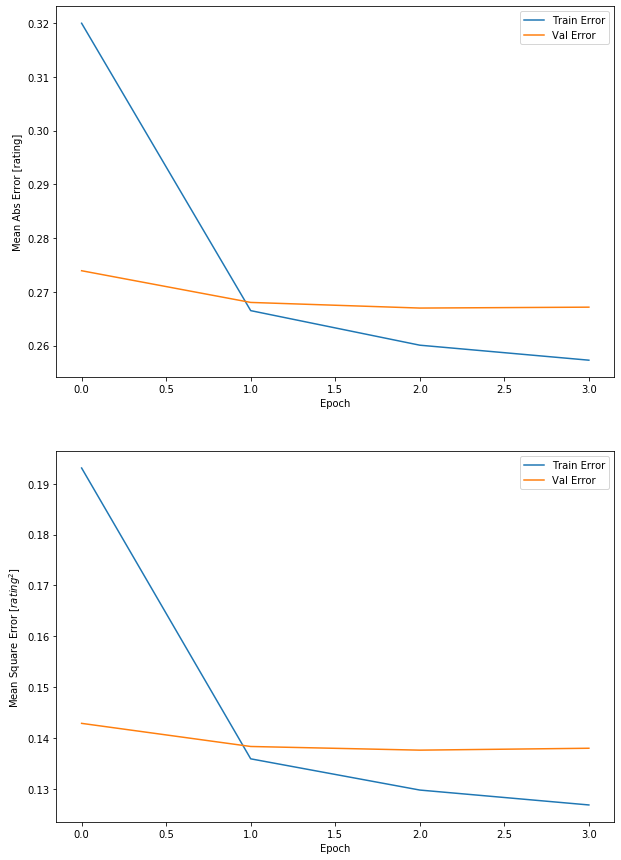

In [51]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    # plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(hist)